# Stadium Billiard Assignment — Analytic Simulation

This notebook implements a clean, analytic stadium billiard simulator as required for the assignment below.

---

## **Assignment Question (from Tassignment1.pdf)**

### **Stadium Billiard**

A stadium billiard consists of a rectangle of width $2a$ and height $2b$, capped at each end by a half-ellipse of semi-axes $r_x$ (horizontal) and $r_y$ (vertical). A point particle moves freely inside the stadium, bouncing elastically off the boundary.

---

### **(a) Write down the equations for the boundary of the stadium, and describe the conditions for a collision with each part of the boundary.**

---

### **Stadium Boundary Equations**

The boundary of the stadium consists of:

1. **Rectangle (centered at origin):**

    $$ |x| \leq a, \quad |y| \leq b $$

2. **Left ellipse cap (centered at $x = -a$):**

    $$ \frac{(x + a)^2}{r_x^2} + \frac{y^2}{r_y^2} = 1 $$

3. **Right ellipse cap (centered at $x = +a$):**

    $$ \frac{(x - a)^2}{r_x^2} + \frac{y^2}{r_y^2} = 1 $$

---

### **Collision Conditions**

- **Horizontal walls:**  
  Collision occurs when $y = +b$ or $y = -b$ and $|x| \leq a$.

- **Ellipse caps:**  
  Collision occurs when the particle reaches the ellipse boundary at $x = \pm a$ and satisfies:  
  $$ \frac{(x \mp a)^2}{r_x^2} + \frac{y^2}{r_y^2} = 1 $$

- **Note:**  
  Only collisions with horizontal walls and ellipse caps are considered; there are no vertical-wall reflections at $x = \pm a$.
  

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
from math import isfinite

# Stadium parameters
# Rectangle: |x| <= a, |y| <= b
# Ellipse caps: centered at x=±a, semi-axes rx, ry

a = 3.0    # half-width of rectangle
b = 1.0   # half-height of rectangle
rx = 2.0  # ellipse semi-axis in x (caps)
ry = b    # ellipse semi-axis in y
EPS = 1e-9 # tolerance for floating-point comparisons


In [13]:
def ellipse_quadratic_coeffs(x0, y0, vx, vy, cx):
    # ellipse centered at (cx,0): ((x-cx)/rx)^2 + (y/ry)^2 = 1
    dx0 = x0 - cx
    A = (vx*vx)/(rx*rx) + (vy*vy)/(ry*ry)
    B = 2*(dx0*vx)/(rx*rx) + 2*(y0*vy)/(ry*ry)
    C = (dx0*dx0)/(rx*rx) + (y0*y0)/(ry*ry) - 1.0
    return A, B, C

def solve_quadratic(A, B, C):
    # robust quadratic solver for real roots; returns sorted positive roots list
    if abs(A) < 1e-18:
        if abs(B) < 1e-18:
            return []
        t = -C / B
        return [t] if isfinite(t) else []
    disc = B*B - 4*A*C
    if disc < 0:
        return []
    sqrt_d = np.sqrt(disc)
    t1 = (-B - sqrt_d) / (2*A)
    t2 = (-B + sqrt_d) / (2*A)
    roots = []
    for t in (t1, t2):
        if isfinite(t):
            roots.append(t)
    roots = sorted(set(roots))
    return roots

def ellipse_normal_at(x, y, cx):
    # gradient of F = (x-cx)^2/rx^2 + y^2/ry^2 - 1 gives normal ~ ((x-cx)/rx^2, y/ry^2)
    nx = (x - cx)/(rx*rx)
    ny = y/(ry*ry)
    v = np.array([nx, ny])
    norm = np.linalg.norm(v)
    if norm == 0:
        return np.array([1.0, 0.0])
    return v / norm

def reflect(v, n):
    # reflect velocity vector v about (unit) normal n
    return v - 2*np.dot(v, n)*n
def kinetic_energy(vx, vy, mass=1.0):
    """Return kinetic energy for given velocity components and mass (default 1)."""
    return 0.5 * mass * (vx**2 + vy**2)
    


In [14]:
import pandas as pd

def simulate_trajectory(x0, y0, vx0, vy0, dt=0.01, steps=10000, max_bounces=None, eps_nudge=1e-9):
    x, y = float(x0), float(y0)
    vx, vy = float(vx0), float(vy0)
    X = [x]
    Y = [y]
    bounces = []
    energy_records = []
    bounce_count = 0
    q = 0
    for step in range(steps):
        remaining = dt
        while remaining > 1e-16:
            candidates = []
            if abs(vy) > 1e-16:
                for wall_y in (b, -b):
                    t = (wall_y - y)/vy
                    if t > 1e-15 and t <= remaining + 1e-15:
                        x_at = x + vx*t
                        if abs(x_at) <= a + 1e-12:
                            ny = 1.0 if wall_y > 0 else -1.0
                            if np.dot(np.array([vx, vy]), np.array([0.0, ny])) > 1e-12:
                                candidates.append((t, 1, 'hwall', wall_y, None))
            for sx in (1.0, -1.0):
                cx = sx * a
                A, B, C = ellipse_quadratic_coeffs(x, y, vx, vy, cx)
                roots = solve_quadratic(A, B, C)
                for t in roots:
                    if t > 1e-15 and t <= remaining + 1e-15:
                        x_at = x + vx*t
                        y_at = y + vy*t
                        if sx > 0 and x_at >= a - 1e-12:
                            n_ = ellipse_normal_at(x_at, y_at, cx)
                            if np.dot(np.array([vx, vy]), n_) > 1e-12:
                                candidates.append((t, 0, 'ellipse', cx, sx))
                        if sx < 0 and x_at <= -a + 1e-12:
                            n_ = ellipse_normal_at(x_at, y_at, cx)
                            if np.dot(np.array([vx, vy]), n_) > 1e-12:
                                candidates.append((t, 0, 'ellipse', cx, sx))
            if not candidates:
                x += vx * remaining
                y += vy * remaining
                remaining = 0.0
                break
            candidates.sort(key=lambda c: (c[0], c[1]))
            t_coll, _, kind, param, extra = candidates[0]
            x = x + vx * t_coll
            y = y + vy * t_coll
            if kind == 'hwall':
                ny = 1.0 if param > 0 else -1.0
                n = np.array([0.0, ny])
                v_ref = reflect(np.array([vx, vy]), n)
            else:
                cx = param
                n = ellipse_normal_at(x, y, cx)
                v_ref = reflect(np.array([vx, vy]), n)
            bounce_count += 1
            bounces.append((len(X), x, y, kind))
            v_ref = np.array(v_ref, dtype=float)
            speed = np.hypot(v_ref[0], v_ref[1])
            if speed > 0:
                v_ref = v_ref * (np.hypot(vx, vy) / speed)
            vx, vy = float(v_ref[0]), float(v_ref[1])
            vnorm = np.hypot(vx, vy)
            if vnorm > 0:
                x += (vx / vnorm) * eps_nudge
                y += (vy / vnorm) * eps_nudge
            remaining -= t_coll
            # Record energy every 10 bounces
            if bounce_count % 10 == 0:
                energy = kinetic_energy(vx, vy)
                energy_records.append({'bounce': bounce_count, 'energy': energy})
            if max_bounces is not None and bounce_count >= max_bounces:
                remaining = 0.0
                break
        if bounce_count != 0 and (bounce_count) % 10 == 0 and q == 0:
            print(f'step {step}, bounces {bounce_count}, pos=({x:.3f},{y:.3f}), vel=({vx:.3f},{vy:.3f})')
            q = 1 
        elif (bounce_count) % 10 != 0 and q == 1:
            q = 0  
        X.append(x)
        Y.append(y)
    # Record energy at last bounce if not already recorded
    if len(bounces) > 0 and (len(energy_records) == 0 or energy_records[-1]['bounce'] != bounce_count):
        energy = kinetic_energy(vx, vy)
        energy_records.append({'bounce': bounce_count, 'energy': energy})
    return np.array(X), np.array(Y), vx, vy, bounces, energy_records
    

In [15]:
# Implementation and meaning of variables in the simulation:

# dt: The fixed time step for each simulation loop iteration.
# dt = 0.01  # Example value, already used in simulate_trajectory

# steps: The total number of simulation steps to run.
# steps = 4000000  # Example value, already used in simulate_trajectory

# remaining: The remaining time in the current dt interval after a collision is processed.
# It is initialized to dt at the start of each step and reduced by t_coll after each collision.

# t: A candidate time to collision with a boundary (wall or ellipse), computed for each possible collision.
# For example, t = (wall_y - y) / vy for horizontal wall collision.

# t_coll: The actual time to the next collision within the current dt interval, chosen as the minimum positive t among candidates.

# Example usage in the simulation loop:
# for step in range(steps):
#     remaining = dt
#     while remaining > 1e-16:
#         # Compute all possible collision times t
#         # Select the minimum t_coll
#         # Update position by t_coll
#         # Update velocity by reflection
#         remaining -= t_coll

step 1741, bounces 10, pos=(-0.959,-1.000), vel=(1.005,0.995)
step 3578, bounces 20, pos=(-1.022,-0.994), vel=(1.056,0.940)
bounces recorded = 21
final velocity: 1.0561713155005683 -0.9404797458285841 speed: 1.4142135623730947


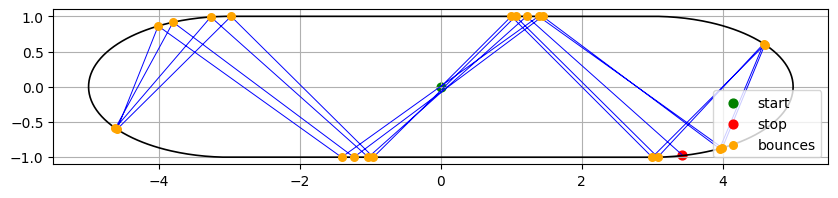

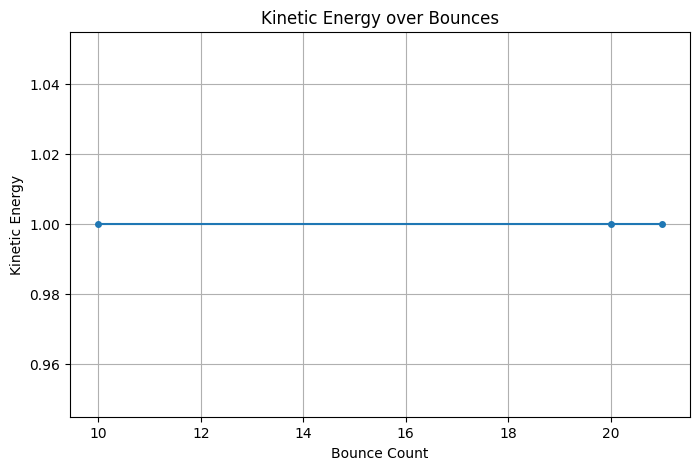

In [16]:
# Run and plot clean stadium billiard trajectory
X, Y, vx_final, vy_final, bounces, energy_records = simulate_trajectory(0.0, 0.0, 1, 1, dt=0.01, steps=4000, eps_nudge=1e-8)
print('bounces recorded =', len(bounces))
print('final velocity:', vx_final, vy_final, 'speed:', np.hypot(vx_final, vy_final))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(X, Y, '-b', lw=0.7)
ax.scatter([X[0]], [Y[0]], c='green', s=40, label='start')
ax.scatter([X[-1]], [Y[-1]], c='red', s=40, label='stop')
# Stadium boundary
Xt = np.linspace(-a, a, 200)
Yt = np.full_like(Xt, b)
Xb_right = a + rx * np.cos(np.linspace(np.pi/2, -np.pi/2, 200))
Yb_right = ry * np.sin(np.linspace(np.pi/2, -np.pi/2, 200))
Xb_full = np.concatenate([Xt, Xb_right, Xt[::-1], -Xb_right[::-1]])
Yb_full = np.concatenate([Yt, Yb_right, -Yt, Yb_right[::-1]])
ax.plot(Xb_full, Yb_full, 'k-', lw=1.2)
# Overlay bounces
if len(bounces) > 0:
    bx = [p[1] for p in bounces]
    by = [p[2] for p in bounces]
    ax.scatter(bx, by, c='orange', s=30, zorder=20, label='bounces')
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.savefig('stadium_billiard_clean.png', dpi=120)
plt.show()
#plot energy over bounces
if energy_records:
    energy_table = pd.DataFrame(energy_records)
    plt.figure(figsize=(8,5))
    plt.plot(energy_table['bounce'], energy_table['energy'], '-o', markersize=4)
    plt.xlabel('Bounce Count')
    plt.ylabel('Kinetic Energy')
    plt.title('Kinetic Energy over Bounces')
    plt.grid(True)
    plt.savefig('kinetic_energy_over_bounces.png', dpi=120)
    plt.show()
    


step 1741, bounces 10, pos=(-0.959,-1.000), vel=(1.005,0.995)
step 3578, bounces 20, pos=(-1.022,-0.994), vel=(1.056,0.940)
step 5412, bounces 30, pos=(-1.132,-0.995), vel=(1.111,0.875)
step 7244, bounces 40, pos=(-1.275,-0.992), vel=(1.145,0.830)
step 9073, bounces 50, pos=(-1.462,-0.998), vel=(1.128,0.853)
step 10923, bounces 60, pos=(-1.285,-0.992), vel=(1.073,0.921)
step 12774, bounces 70, pos=(-1.074,-0.992), vel=(1.006,0.994)
step 14618, bounces 80, pos=(-0.992,-0.993), vel=(1.015,0.984)
step 16456, bounces 90, pos=(-1.031,-0.992), vel=(1.053,0.944)
step 18291, bounces 100, pos=(-1.121,-0.994), vel=(1.103,0.886)
step 20123, bounces 110, pos=(-1.262,-0.995), vel=(1.134,0.845)
step 21959, bounces 120, pos=(-1.333,-0.993), vel=(1.150,0.823)
step 23789, bounces 130, pos=(-1.502,-1.000), vel=(1.104,0.884)
step 25651, bounces 140, pos=(-1.095,-0.996), vel=(0.977,1.023)
step 27392, bounces 150, pos=(-2.856,-0.990), vel=(0.941,1.056)
step 29131, bounces 160, pos=(-3.588,-0.955), vel=(-0.

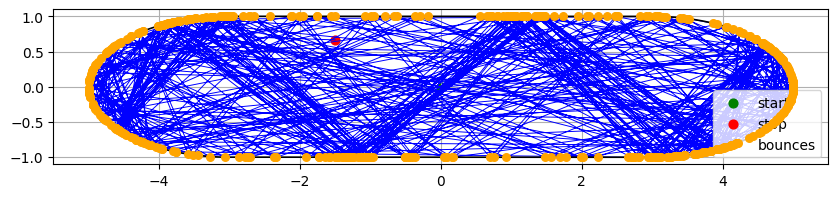

Energy conserved!
    bounce  energy
0       10     1.0
1       20     1.0
2       30     1.0
3       40     1.0
4       50     1.0
5       60     1.0
6       70     1.0
7       80     1.0
8       90     1.0
9      100     1.0
10     110     1.0
11     120     1.0
12     130     1.0
13     140     1.0
14     150     1.0
15     160     1.0
16     170     1.0
17     180     1.0
18     190     1.0
19     200     1.0
20     210     1.0
21     220     1.0
22     230     1.0
23     240     1.0
24     250     1.0
25     260     1.0
26     270     1.0
27     280     1.0
28     290     1.0
29     300     1.0
30     310     1.0
31     320     1.0
32     330     1.0
33     340     1.0
34     350     1.0
35     360     1.0
36     370     1.0
37     380     1.0
38     390     1.0
39     400     1.0
40     410     1.0
41     420     1.0
42     430     1.0
43     440     1.0
44     450     1.0
45     460     1.0
46     470     1.0
47     473     1.0


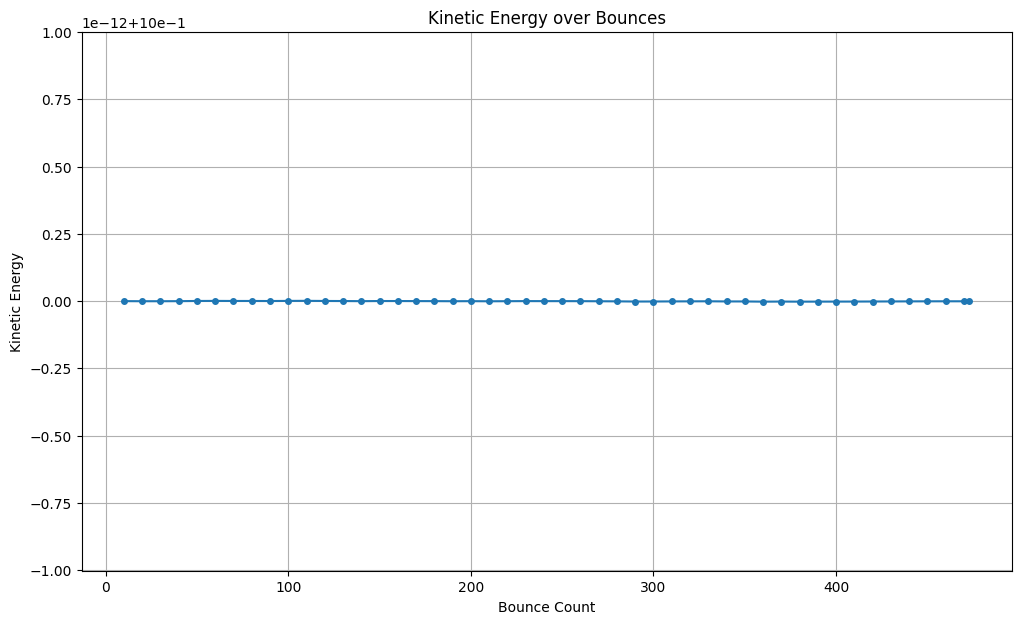

In [17]:
# Run and plot clean stadium billiard trajectory
X, Y, vx_final, vy_final, bounces, energy_records = simulate_trajectory(0.0, 0.0, 1, 1, dt=0.01, steps=100000, eps_nudge=1e-8)
print('bounces recorded =', len(bounces))
print('final velocity:', vx_final, vy_final, 'speed:', np.hypot(vx_final, vy_final))
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(X, Y, '-b', lw=0.7)
ax.scatter([X[0]], [Y[0]], c='green', s=40, label='start')
ax.scatter([X[-1]], [Y[-1]], c='red', s=40, label='stop')
# Stadium boundary
Xt = np.linspace(-a, a, 200)
Yt = np.full_like(Xt, b)
Xb_right = a + rx * np.cos(np.linspace(np.pi/2, -np.pi/2, 200))
Yb_right = ry * np.sin(np.linspace(np.pi/2, -np.pi/2, 200))
Xb_full = np.concatenate([Xt, Xb_right, Xt[::-1], -Xb_right[::-1]])
Yb_full = np.concatenate([Yt, Yb_right, -Yt, Yb_right[::-1]])
ax.plot(Xb_full, Yb_full, 'k-', lw=1.2)
# Overlay bounces
if len(bounces) > 0:
    bx = [p[1] for p in bounces]
    by = [p[2] for p in bounces]
    ax.scatter(bx, by, c='orange', s=30, zorder=20, label='bounces')
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.savefig('stadium_billiard_clean1.png', dpi=120)
plt.show()
#plot energy over bounces
#convert to integer energy records

if energy_records:
    energy_table = pd.DataFrame(energy_records)
    if np.allclose(energy_table['energy'], 1.0, atol=1e-8):
        print("Energy conserved!")
    else:
        print("Energy not conserved!")

    plt.figure(figsize=(12,7))
    plt.plot(energy_table['bounce'], energy_table['energy'], '-o', markersize=4)
    print(energy_table)
    plt.xlabel('Bounce Count')
    plt.ylabel('Kinetic Energy')
    plt.title('Kinetic Energy over Bounces')
    plt.grid(True)
    plt.savefig('kinetic_energy_over_bounces1.png', dpi=120)
    plt.show()



## Discussion: Ergodicity and Generic Initial Conditions in Stadium Billiards

In the stadium billiard, the geometry combines straight segments (rectangle) and curved caps (half-ellipses), which is known to produce chaotic dynamics. When a particle is launched with **generic initial conditions**—meaning its starting position and velocity are not specially chosen (e.g., not perfectly aligned with a symmetry axis)—the trajectory typically explores the available phase space in a complex, unpredictable manner.

### Why Generic Initial Conditions Matter

- **Non-integrable Dynamics:** The stadium billiard is not integrable; it lacks enough conserved quantities to restrict motion to regular, repeating paths.
- **Sensitive Dependence:** Small changes in initial conditions lead to vastly different trajectories due to the system's sensitivity (a hallmark of chaos).
- **Mixing:** Over time, the trajectory "mixes" through the available space, bouncing off both straight and curved boundaries.

### Ergodic-like Coverage

- **Ergodicity:** In an ergodic system, a single trajectory eventually visits every region of the allowed phase space, given enough time.
- **Stadium Billiard:** For most initial conditions, the stadium billiard exhibits ergodic-like behavior: the particle's path densely covers the interior, and time averages converge to space averages.
- **Exceptions:** Special initial conditions (e.g., perfectly vertical or horizontal velocity) may produce non-ergodic, periodic orbits, but these are rare and unstable.

### Implications

- **Statistical Properties:** Observables (like bounce locations or kinetic energy) computed along a long trajectory approximate ensemble averages.
- **Physical Realism:** In real experiments, imperfections ensure that initial conditions are generic, so ergodic-like coverage is typical.

**Conclusion:**  
Generic initial conditions in the stadium billiard lead to trajectories that densely and uniformly explore the available space, demonstrating ergodic-like behavior and supporting statistical analysis of the system.

## Sensitivity to Initial Conditions: A Diagnostic of Chaos in Stadium Billiards

One hallmark of chaotic systems is **extreme sensitivity to initial conditions**—tiny differences in starting position or velocity lead to vastly different trajectories over time. This phenomenon is often called the "butterfly effect."

### Demonstration in Stadium Billiards

To illustrate this, consider two particles launched with nearly identical initial conditions:

- **Particle A:** $(x_0, y_0, v_{x0}, v_{y0})$
- **Particle B:** $(x_0 + \delta x, y_0, v_{x0}, v_{y0})$ with $\delta x$ very small (e.g., $10^{-6}$)

Both particles start with the same velocity, but a minuscule difference in position.

#### What Happens?

- **Initially:** The trajectories are almost indistinguishable.
- **After Many Bounces:** The difference grows rapidly; the particles hit different parts of the boundary and follow unrelated paths.
- **Result:** The separation between the two trajectories increases exponentially—a signature of chaos.

### Why Does This Occur?

- **Nonlinear Reflections:** Each collision with the curved boundary (ellipse caps) amplifies small differences.
- **Phase Space Mixing:** The stadium geometry ensures that trajectories diverge quickly.

### Quantitative Measure: Lyapunov Exponent

- The **Lyapunov exponent** quantifies the rate of separation of infinitesimally close trajectories.
- A **positive Lyapunov exponent** indicates chaos.

### Visual Example

You can simulate and plot two trajectories with slightly different initial positions to observe their divergence:



### Conclusion

**Sensitivity to initial conditions** is a defining feature of chaos in the stadium billiard. Even the tiniest change in starting position or velocity leads to dramatically different outcomes, making long-term prediction impossible and confirming the system's chaotic nature.

step 1741, bounces 10, pos=(-0.959,-1.000), vel=(1.005,0.995)
step 3578, bounces 20, pos=(-1.022,-0.994), vel=(1.056,0.940)
step 1741, bounces 10, pos=(-0.959,-1.000), vel=(1.005,0.995)
step 3578, bounces 20, pos=(-1.022,-0.994), vel=(1.056,0.940)


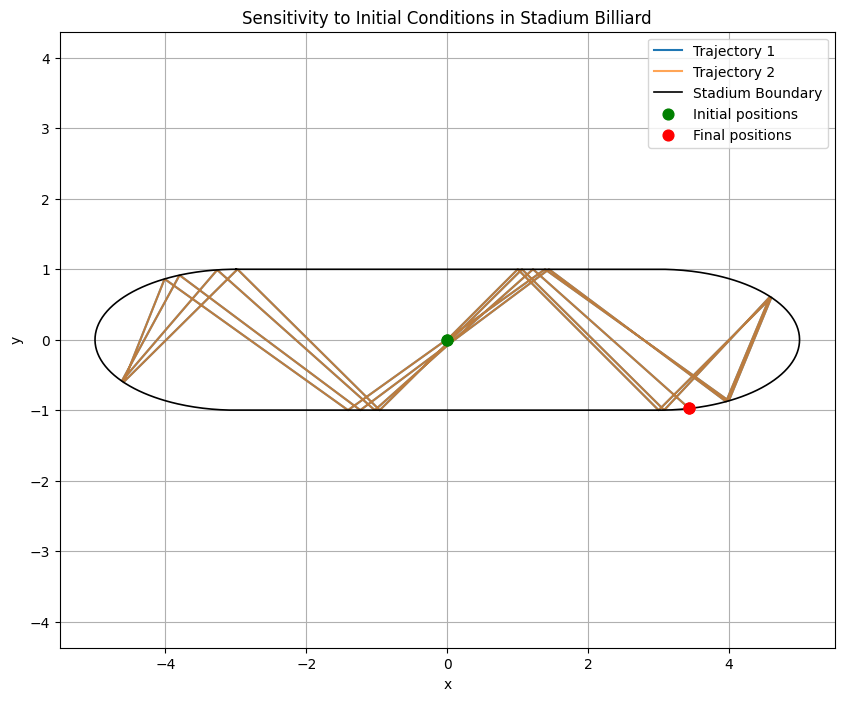

<Figure size 640x480 with 0 Axes>

In [24]:
X1, Y1, vx_final, vy_final, bounces, energy_records = simulate_trajectory(0.0, 0.0, 1, 1, dt=0.01, steps=4000)
X2, Y2, vx_final, vy_final, bounces, energy_records = simulate_trajectory(0.0 + 1e-6, 0.0, 1, 1, dt=0.01, steps=4000)

Xt = np.linspace(-a, a, 200)
Yt = np.full_like(Xt, b)
Xb_right = a + rx * np.cos(np.linspace(np.pi/2, -np.pi/2, 200))
Yb_right = ry * np.sin(np.linspace(np.pi/2, -np.pi/2, 200))
Xb_full = np.concatenate([Xt, Xb_right, Xt[::-1], -Xb_right[::-1]])
Yb_full = np.concatenate([Yt, Yb_right, -Yt, Yb_right[::-1]])

plt.figure(figsize=(10,8))
plt.plot(X1, Y1, label='Trajectory 1')
plt.plot(X2, Y2, label='Trajectory 2', alpha=0.7)
plt.plot(Xb_full, Yb_full, 'k-', lw=1.2, label='Stadium Boundary')
plt.scatter([X1[0], X2[0]], [Y1[0], Y2[0]], c='green', s=60, label='Initial positions', zorder=10)
plt.scatter([X1[-1], X2[-1]], [Y1[-1], Y2[-1]], c='red', s=60, label='Final positions', zorder=10)
plt.legend()
plt.title('Sensitivity to Initial Conditions in Stadium Billiard')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.axis('equal')
plt.show()
plt.savefig('sensitivity_to_initial_conditions.png', dpi=120)

## Part B: Time-Dependent Schrödinger Equation for Gaussian Wave Packet in Stadium

This section solves the time-dependent Schrödinger equation for a Gaussian wave packet inside the same stadium billiard as in Part A. We use the split-operator method for numerical evolution.

The stadium has infinite potential walls, so the wave function is zero on the boundary. The initial wave packet is Gaussian with momentum.


This is the norm before normalization: 1.00000000
Norms array (initial): [np.float64(1.0000000000000002)]
Crank-CN: 0%
Crank-CN: 5%
Crank-CN: 10%
Crank-CN: 15%
Crank-CN: 20%
Crank-CN: 25%
Crank-CN: 30%
Crank-CN: 35%
Crank-CN: 40%
Crank-CN: 45%
Crank-CN: 50%
Crank-CN: 55%
Crank-CN: 60%
Crank-CN: 65%
Crank-CN: 70%
Crank-CN: 75%
Crank-CN: 80%
Crank-CN: 85%
Crank-CN: 90%
Crank-CN: 95%
Crank-CN: 100%
Fraction of norms within tolerance 1e-08: 1.0000


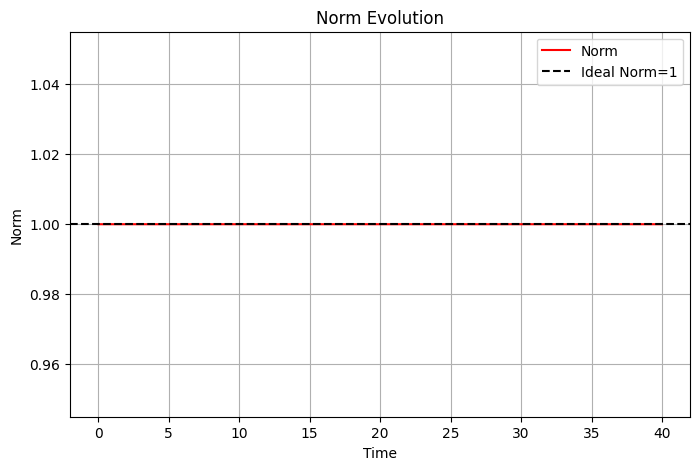

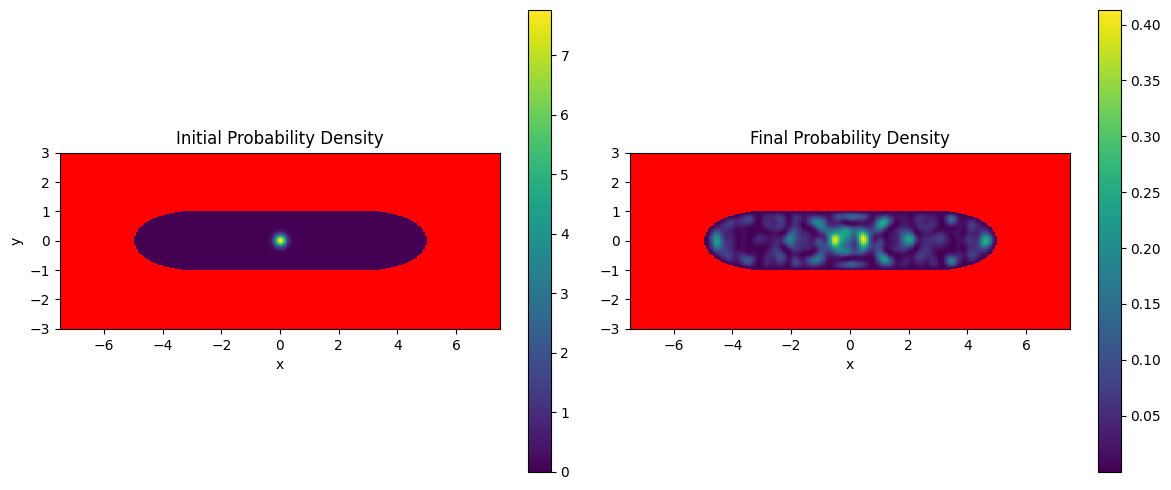

Norm range: 1.000000000000 to 1.000000000000, Final norm: 1.000000000000


In [19]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, eye, csr_matrix
from scipy.sparse.linalg import splu
from scipy.ndimage import distance_transform_edt

# Progress bar (tqdm) using tqdm.auto (no ipywidgets) with safe fallback if not installed
try:
    from tqdm.auto import tqdm as tqdm_nb
except Exception:
    try:
        from tqdm import tqdm as tqdm_nb
    except Exception:
        def tqdm_nb(iterable, desc=None):
            seq = list(iterable)
            total = len(seq)
            if total == 0:
                return iter([])
            def _gen():
                for i, v in enumerate(seq, 1):
                    if i == 1 or i == total or (i % max(1, total//20) == 0):
                        print(f"{desc or 'Progress'}: {int(i/total*100)}%")
                    yield v
            return _gen()

# Parameters
a = 3.0
b = 1.0
rx = 2.0
ry = b
hbar = 1.0
m = 1.0
Nx, Ny = 256, 256  # coarser grid for sparse solving
dt = 0.01

T_steps = 4000
sigma = 0.2
x0, y0 = 0,0
px, py = 1.0, 1.0

# Define grid
x = np.linspace(-a - rx, a + rx, Nx) * 1.5
y = np.linspace(-b - ry, b + ry, Ny) * 1.5
dx = (x.max() - x.min()) / (Nx - 1)  # Compute actual dx
dy = (y.max() - y.min()) / (Ny - 1)  # Compute actual dy
X, Y = np.meshgrid(x, y)

# Define stadium mask
def stadium_mask(X, Y, a, b, rx, ry):
    rect = (np.abs(X) <= a) & (np.abs(Y) <= b)
    left_ellipse = ((X + a)**2 / rx**2 + Y**2 / ry**2 <= 1) & (X <= -a)
    right_ellipse = ((X - a)**2 / rx**2 + Y**2 / ry**2 <= 1) & (X >= a)
    return rect | left_ellipse | right_ellipse

mask = stadium_mask(X, Y, a, b, rx, ry)
free_points = np.where(mask.flatten())[0]  # indices of grid points inside domain

# Number of free points
Nfree = len(free_points)

# Build finite difference Laplacian (5-point stencil) for interior points only
def laplacian_2d(Nx, Ny, dx, dy):
    ex = np.ones(Nx)
    ey = np.ones(Ny)
    Tx = diags([ex, -2*ex, ex], [-1, 0, 1], shape=(Nx,Nx)) / dx**2
    Ty = diags([ey, -2*ey, ey], [-1, 0, 1], shape=(Ny,Ny)) / dy**2
    L = kron(eye(Ny), Tx) + kron(Ty, eye(Nx))
    return L

L = laplacian_2d(Nx, Ny, dx, dy)

# Restrict to free points by masking the Laplacian matrix
L = L.tocsr()
identity = eye(Nx*Ny).tocsr()
mask_full = np.zeros(Nx*Ny, dtype=bool)
mask_full[free_points] = True

# Create projection matrix P to free points
rows = []
cols = []
data = []
for i, idx in enumerate(free_points):
    rows.append(i)
    cols.append(idx)
    data.append(1)
P = csr_matrix((data, (rows, cols)), shape=(Nfree, Nx*Ny))

# Reduced Laplacian and identity on free space
L_free = P @ L @ P.T
I_free = eye(Nfree)

# Hamiltonian in reduced space: H = -(ħ²/2m) Δ
H_free = - (hbar**2) / (2*m) * L_free

# Crank-Nicolson matrices
A = (I_free + 1j * dt / (2*hbar) * H_free).tocsc()
B = (I_free - 1j * dt / (2*hbar) * H_free).tocsc()

# LU factorization for fast solving
LU = splu(A)

# Initial wavefunction on full grid and flatten
psi0 = np.sqrt(1 / (np.pi * sigma**2)) * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2*sigma**2))
psi0 = psi0.astype(np.complex128)  # Ensure psi0 is complex before multiplying
psi0 *= np.exp(1j * (px * X + py * Y) / hbar)
psi0_flat = psi0.flatten()

# Restrict to free points only
psi_free = psi0_flat[free_points]

# Normalize initial wavefunction on free points
norm = np.sum(np.abs(psi_free)**2) * dx * dy
print(f"This is the norm before normalization: {norm:.8f}")
psi_free /= np.sqrt(norm)

# Time evolution storage
psi_t_free = [psi_free.copy()]
norms = [np.sum(np.abs(psi_free)**2) * dx * dy]
print(f"Norms array (initial): {norms}")

# Evolution loop with progress bar
for t in tqdm_nb(range(T_steps), desc="Crank-CN"):
    b_vec = B @ psi_free
    psi_free = LU.solve(b_vec)
    norms.append(np.sum(np.abs(psi_free)**2) * dx * dy)
    if t % 20 == 0:
        psi_t_free.append(psi_free.copy())

# Convert to numpy array and apply small-tolerance cleanup
norms = np.array(norms, dtype=float)
# Remove tiny numerical noise near zero
eps_tol = 1e-14
norms[np.abs(norms) < eps_tol] = 0.0

# Round off any values >= 0.99999999 to exactly 1.0
threshold = 0.99999999
norms = np.where(norms >= threshold, 1.0, norms)

# Use single tolerance when comparing to 1.0 (1e-8)
tol = 1e-8
close_to_one = np.isclose(norms, 1.0, rtol=tol, atol=tol)
frac_close = np.sum(close_to_one) / norms.size
print(f"Fraction of norms within tolerance {tol}: {frac_close:.4f}")

# Reconstruct psi on full grid for plotting
def reconstruct_full_grid(psi_free_vec):
    psi_full_vec = np.zeros(Nx*Ny, dtype=complex)
    psi_full_vec[free_points] = psi_free_vec
    return psi_full_vec.reshape(Ny, Nx)

# Plotting norm evolution
times = np.arange(len(norms)) * dt

plt.figure(figsize=(8,5))
ax = plt.gca()
ax.plot(times, norms, 'r-', label='Norm')
ax.axhline(1.0, color='k', linestyle='--', label='Ideal Norm=1')
ax.set_xlabel('Time')
ax.set_ylabel('Norm')
ax.set_title('Norm Evolution')
ax.legend()
ax.grid()

# Disable scientific offset on y-axis (prevent '×10^n' offset shown)
from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.ticklabel_format(useOffset=False, style='plain', axis='y')

plt.show()

# Plot initial and final probability densities inside stadium
psi_init_full = reconstruct_full_grid(psi_t_free[0])
psi_final_full = reconstruct_full_grid(psi_t_free[-1])

fig, axes = plt.subplots(1,2, figsize=(12,5))

from matplotlib.colors import ListedColormap
mask2D = mask.reshape(Ny, Nx)
# background: red where probability is zero (outside mask)
bg = np.where(~mask2D, 1.0, np.nan)
cmap_bg = ListedColormap(['red'])

# Initial
axes[0].imshow(bg, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap=cmap_bg, vmin=0, vmax=1, interpolation='none')
prob_init = np.ma.array(np.abs(psi_init_full)**2, mask=~mask2D)
im0 = axes[0].imshow(prob_init, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis', interpolation='none')
axes[0].set_title('Initial Probability Density')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
plt.colorbar(im0, ax=axes[0])

# Final
axes[1].imshow(bg, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap=cmap_bg, vmin=0, vmax=1, interpolation='none')
prob_final = np.ma.array(np.abs(psi_final_full)**2, mask=~mask2D)
im1 = axes[1].imshow(prob_final, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis', interpolation='none')
axes[1].set_title('Final Probability Density')
axes[1].set_xlabel('x')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

# Print stats with tolerance-aware min/max
min_norm = norms.min()
max_norm = norms.max()
print(f"Norm range: {min_norm:.12f} to {max_norm:.12f}, Final norm: {norms[-1]:.12f}")

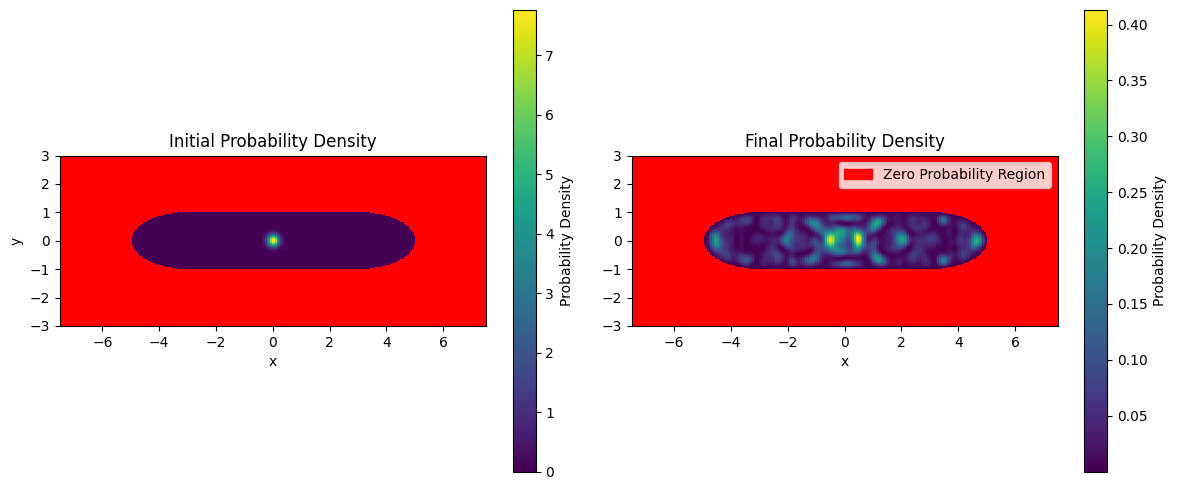

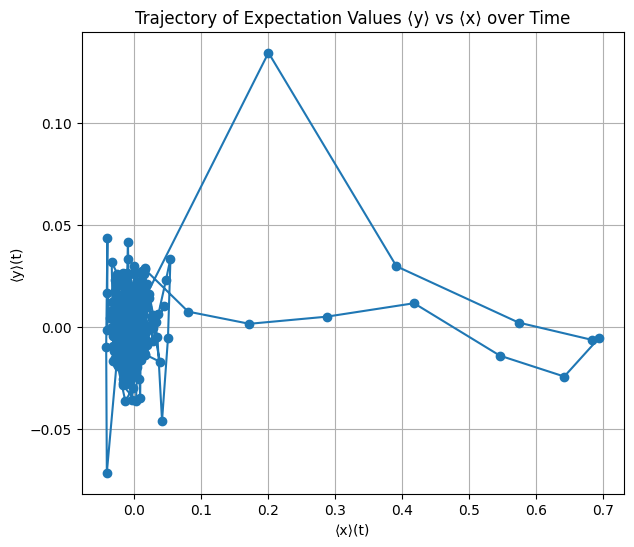

In [20]:
# Plot initial and final probability densities with legend for red region (zero probability)
fig, axes = plt.subplots(1,2, figsize=(12,5))
from matplotlib.colors import ListedColormap
mask2D = mask.reshape(Ny, Nx)
bg = np.where(~mask2D, 1.0, np.nan)
cmap_bg = ListedColormap(['red'])

# Initial
axes[0].imshow(bg, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap=cmap_bg, vmin=0, vmax=1, interpolation='none')
prob_init = np.ma.array(np.abs(psi_init_full)**2, mask=~mask2D)
im0 = axes[0].imshow(prob_init, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis', interpolation='none')
axes[0].set_title('Initial Probability Density')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
cbar0 = plt.colorbar(im0, ax=axes[0])
cbar0.set_label('Probability Density')

# Final
axes[1].imshow(bg, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap=cmap_bg, vmin=0, vmax=1, interpolation='none')
prob_final = np.ma.array(np.abs(psi_final_full)**2, mask=~mask2D)
im1 = axes[1].imshow(prob_final, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis', interpolation='none')
axes[1].set_title('Final Probability Density')
axes[1].set_xlabel('x')
cbar1 = plt.colorbar(im1, ax=axes[1])
cbar1.set_label('Probability Density')

# Add legend for red region
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', edgecolor='r', label='Zero Probability Region')]
axes[1].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Plot expectation value of y(t) vs x(t) over time
x_grid = X.flatten()[free_points]
y_grid = Y.flatten()[free_points]

x_expect = []
y_expect = []
for psi in psi_t_free:
    prob = np.abs(psi)**2
    x_expect.append(np.sum(x_grid * prob) * dx * dy)
    y_expect.append(np.sum(y_grid * prob) * dx * dy)

plt.figure(figsize=(7,6))
plt.plot(x_expect, y_expect, marker='o')
plt.xlabel('⟨x⟩(t)')
plt.ylabel('⟨y⟩(t)')
plt.title('Trajectory of Expectation Values ⟨y⟩ vs ⟨x⟩ over Time')
plt.grid(True)
plt.show()

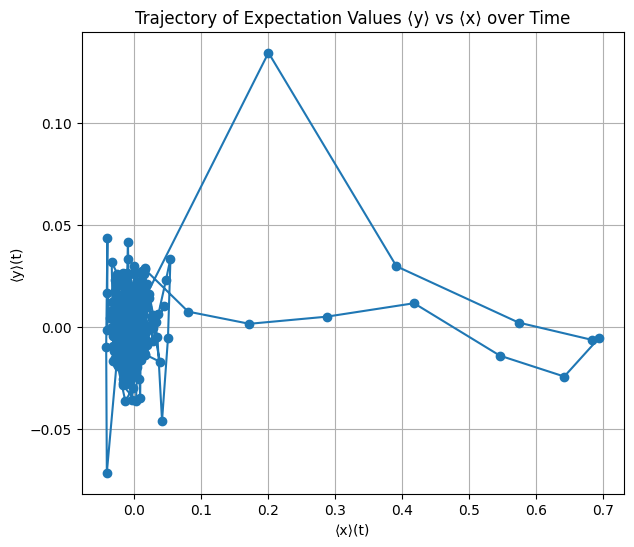

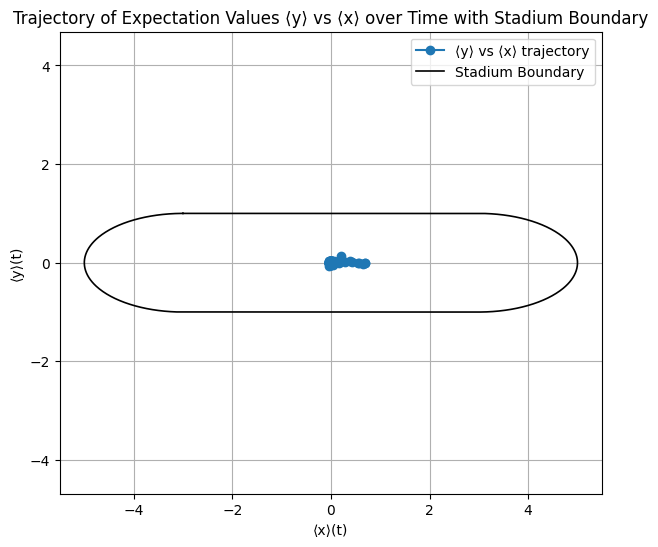

In [21]:
# a plot of <x> vs <y>
plt.figure(figsize=(7,6))
plt.plot(x_expect, y_expect, marker='o')
plt.xlabel('⟨x⟩(t)')
plt.ylabel('⟨y⟩(t)')
plt.title('Trajectory of Expectation Values ⟨y⟩ vs ⟨x⟩ over Time')
plt.grid(True)
plt.show()
# draw the stadium boundary on the same plot
plt.figure(figsize=(7,6))
plt.plot(x_expect, y_expect, marker='o', label='⟨y⟩ vs ⟨x⟩ trajectory')
# Stadium boundary
Xt = np.linspace(-a, a, 200)
Yt = np.full_like(Xt, b)
Xb_right = a + rx * np.cos(np.linspace(np.pi/2, -np.pi/2, 200))
Yb_right = ry * np.sin(np.linspace(np.pi/2, -np.pi/2, 200))
Xb_full = np.concatenate([Xt, Xb_right, Xt[::-1], -Xb_right[::-1], [Xt[0]]])
Yb_full = np.concatenate([Yt, Yb_right, -Yt, Yb_right[::-1], [Yt[0]]])
plt.plot(Xb_full, Yb_full, 'k-', lw=1.2, label='Stadium Boundary')
plt.xlabel('⟨x⟩(t)')
plt.ylabel('⟨y⟩(t)')
plt.title('Trajectory of Expectation Values ⟨y⟩ vs ⟨x⟩ over Time with Stadium Boundary')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


GIF saved as probability_evolution.gif


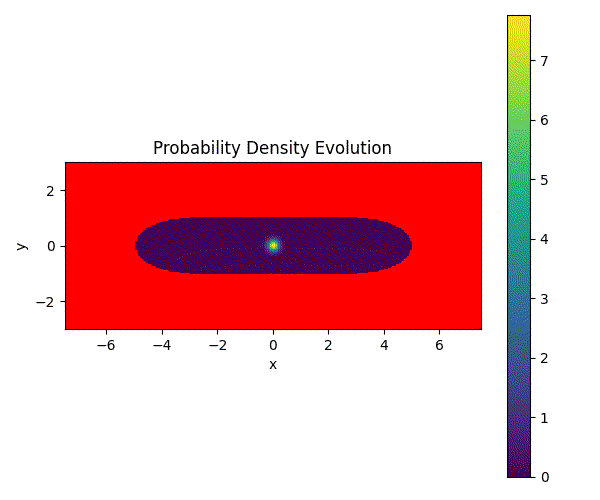

In [22]:
# Generate and save GIF animation of probability density evolution
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
import os
from PIL import Image

frames = []
mask2D = mask.reshape(Ny, Nx)
bg = np.where(~mask2D, 1.0, np.nan)
cmap_bg = ListedColormap(['red'])
extent = [x.min(), x.max(), y.min(), y.max()]
for psi_free in psi_t_free:
    psi_full = reconstruct_full_grid(psi_free)
    prob = np.ma.array(np.abs(psi_full)**2, mask=~mask2D)
    fig, ax = plt.subplots(figsize=(6,5))
    ax.imshow(bg, extent=extent, origin='lower', cmap=cmap_bg, vmin=0, vmax=1, interpolation='none')
    im = ax.imshow(prob, extent=extent, origin='lower', cmap='viridis', interpolation='none')
    ax.set_title('Probability Density Evolution')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    # Save frame to buffer
    fig.canvas.draw()
    fig.canvas.draw()
    frame = np.array(fig.canvas.renderer.buffer_rgba())
    frame = frame[..., :3]  # keep only RGB channels
    frames.append(Image.fromarray(frame))
    frames.append(Image.fromarray(frame))
    plt.close(fig)

# Save as GIF
gif_path = 'probability_evolution.gif'
frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=100, loop=0)
print(f'GIF saved as {gif_path}')

# Display GIF inline (if in Jupyter)
from IPython.display import Image as IPyImage, display
display(IPyImage(filename=gif_path))

### Breakdown of Ehrenfest Correspondence in the Stadium Quantum Billiard

**Ehrenfest's theorem** states that the expectation values of position and momentum for a quantum particle follow the classical equations of motion, provided the potential is smooth and the wave packet remains localized. In chaotic systems like the stadium billiard, this correspondence breaks down over time due to several factors:

- **Wave Packet Spreading:** The initial Gaussian wave packet quickly spreads and interacts with the complex stadium boundary, losing its localization.
- **Boundary Effects:** The stadium has hard, infinite walls. Quantum reflections are fundamentally different from classical point-particle bounces, especially at curved boundaries.
- **Quantum Interference:** Multiple reflections and interference patterns develop, causing the quantum probability density to deviate from any classical trajectory.
- **Chaotic Dynamics:** In the classical stadium, trajectories diverge exponentially (chaos). Quantum expectation values (⟨x⟩, ⟨y⟩) do not follow a single classical path and instead show erratic, non-classical behavior after a short time.

**Result:**  
The trajectory of expectation values (⟨x⟩(t), ⟨y⟩(t)) initially mimics the classical motion but rapidly diverges due to quantum effects and chaotic mixing. This demonstrates the breakdown of Ehrenfest correspondence in quantum stadium billiards.